# Preprocessing notebook

In [ ]:
import polars as pl
from bs4 import BeautifulSoup
import lxml  # Used implictly in BeautifulSoup, but needs to be installed
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import functools
import re
from datetime import datetime
import spacy

# Enable Polars to use all available threads for maximum performance
pl.Config.set_streaming_chunk_size(100000)  # Adjust based on your dataset size

polars.config.Config

## Preprocessing functions

In [2]:
def extract_text_and_code_optimized(html_content):
    """
    Efficiently separates text and code blocks from Stack Overflow HTML content
    """
    # Use lxml parser for speed
    soup = BeautifulSoup(html_content, "lxml")

    # Get all code blocks in a single pass
    code_elements = soup.find_all("code")
    code_blocks = [code.get_text() for code in code_elements]

    # Extract text after removing code (more efficient than decomposing in a loop)
    for code in code_elements:
        code.replace_with(
            " "
        )  # Replace with space instead of removing to maintain text flow

    clean_text = soup.get_text(strip=True)

    return {"text": clean_text, "code": code_blocks}

In [3]:
# Initialize stemmer once
stemmer = PorterStemmer()

# Create stopwords set once
standard_stops = set(stopwords.words("english"))
programming_stops = set()  # Add programming-specific stopwords if needed
combined_stops = standard_stops.union(programming_stops)


# Cache for stemmed words
@functools.lru_cache(maxsize=100000)
def cached_stem(word):
    return stemmer.stem(word)


def preprocess_text(text, remove_stops=True):
    """Process text content with optimizations"""

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stop words and apply stemming more efficiently
    if remove_stops:
        # Use generator expression instead of list comprehension
        return " ".join(
            cached_stem(token) for token in tokens if token not in combined_stops
        )
    else:
        # Use generator expression instead of list comprehension
        return " ".join(cached_stem(token) for token in tokens if token)

In [ ]:
# Load a small, efficient SpaCy model - disable components you don't need
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Create stopwords set using spaCy instead of NLTK
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
programming_stops = set()  # Add programming-specific stopwords if needed
combined_stops = spacy_stopwords.union(programming_stops)


# Cache for lemmatized words
@functools.lru_cache(maxsize=100000)
def cached_lemmatize(word):
    """Lemmatize a single word and cache the result"""
    # Process the word with the full pipeline to get lemma
    doc = nlp(word)  # Use nlp() instead of nlp.make_doc()
    return doc[0].lemma_


def preprocess_text_spacy(text, remove_stops=True):
    """Process text content with SpaCy lemmatization"""

    # Process the entire text through the pipeline
    doc = nlp(text)  # Use full nlp pipeline instead of just tokenizer

    # Apply lemmatization with stop word removal if needed
    if remove_stops:
        return " ".join(
            token.lemma_  # Access lemma_ directly from processed tokens
            for token in doc
            if token.text not in combined_stops and token.text.strip()
        )
    else:
        return " ".join(
            token.lemma_  # Access lemma_ directly from processed tokens
            for token in doc
            if token.text.strip()
        )

## Complete preprocessing pipeline

Use the Polars lazy dataframe implementation to profit from query optimization for large datasets

In [ ]:
# Execute the actual preprocessing pipeline
df = (
    pl.scan_parquet(
        "../data/stackoverflow/stackoverflow_script.parquet"
    )  # "../stackoverflow_sample.parquet")
    # 1. Apply filters early to reduce data volume
    # .filter(pl.col("CreationDate") > "2023-12-31")  # Example early filter
    # 2. Select only needed columns as early as possible
    .select(
        [
            "CreationDate",
            "Score",
            "ViewCount",
            "Title",
            "Body",
            "Tags",
            "AnswerCount",
            "CommentCount",
        ]
    )
    # 3. Process HTML content in one step
    .with_columns(
        pl.col("Body")
        .map_elements(
            extract_text_and_code_optimized,
            return_dtype=pl.Struct(
                [pl.Field("text", pl.Utf8), pl.Field("code", pl.List(pl.Utf8))]
            ),
            # strategy="threading",
        )
        .alias("content"),
        # 4. Process tags in same with_columns operation
        pl.col("Tags")
        .str.strip_prefix("|")
        .str.strip_suffix("|")
        .str.split("|")
        .alias("tag_list"),
    )
    # 5. Extract struct fields and derive new columns in one operation
    .with_columns(
        pl.col("content").struct.field("text").alias("clean_text"),
        pl.col("content").struct.field("code").alias("code_blocks"),
        pl.col("tag_list").list.len().alias("tag_count"),
    )
    .with_columns(
        pl.col("code_blocks").list.join("").str.len_chars().alias("code_length"),
        pl.col("Body").str.len_chars().alias("body_length"),
        pl.col("Title").str.len_chars().alias("title_length"),
    )
    # 6. Apply text preprocessing only after dropping unnecessary columns
    .drop(["Body", "Tags", "content"])
    # 7. Apply expensive text processing operations last
    .with_columns(
        pl.col("clean_text")
        .str.to_lowercase()  # String ops before map_elements
        .str.strip_chars()
        .replace("", None)
        .map_elements(preprocess_text, return_dtype=pl.Utf8(), skip_nulls=True)
        .map_elements(
            preprocess_text_spacy,
            return_dtype=pl.Utf8(),
            skip_nulls=True,
            # strategy="threading",
        )
        .alias("processed_text")
    )
    # 8. Set execution configuration
    .collect(
        streaming=True,
        no_optimization=False,
    )
)

/tmp/ipykernel_12564/899525384.py:70: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it is suggested to pin your version to before 1.23.0.

More information on the new streaming engine: https://github.com/pola-rs/polars/issues/20947
  .collect(


In [ ]:
df.write_parquet("stackoverflow_preprocessed1.parquet")

In [6]:
# Calculate average text length
avg_text_length = df["processed_text"].str.len_chars().mean()
print(f"Average text length: {avg_text_length}")

Average text length: 416.5548656278113


In [7]:
from typing import Optional
import wordcloud
import matplotlib.pyplot as plt

STOP_WORDS = set(stopwords.words("english"))


# Create a WordCloud template
def create_wordcloud(text: str, title: Optional[str] = None) -> wordcloud.WordCloud:
    """Create a WordCloud object from the given text."""
    wc = wordcloud.WordCloud(
        width=2400,
        height=1200,
        background_color="white",
        colormap="viridis",
        stopwords=STOP_WORDS,
    )
    wc.generate(text)
    # wc.recolor(color_func=wordcloud.get_single_color_func('darkblue'))
    # if title:
    # with open(f"imgs/{title}.svg", "w") as f:
    #     f.write(wc.to_svg(embed_font=True))
    # wc.to_file(f"imgs/wordclouds/{title}.png")

    # Set the figure size - width and height in inches
    plt.figure(figsize=(16, 10))

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

    plt.show()

In [8]:
df1 = df.filter(pl.col("processed_text").str.len_chars() > 0)
text = " ".join(df1["processed_text"].to_list())

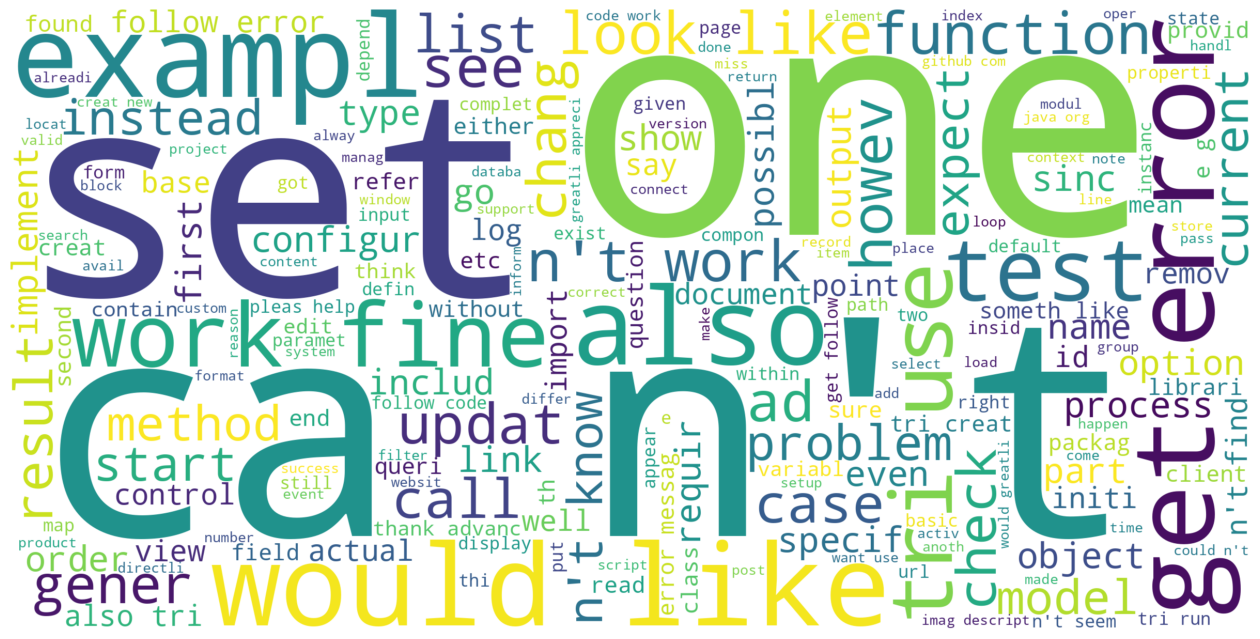

In [9]:
# Create and display the WordCloud
create_wordcloud(text, "wordcloud_test")